In [1]:
!pip install gym_sokoban

In [1]:
import argparse
import gym
import gym
import gym_sokoban
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import torchvision

from torchvision.transforms.functional import InterpolationMode
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import math
import random 
import pandas as pd 
import seaborn as sns

In [13]:
image_transformations = T.Compose([
                    T.ToPILImage(),
                    T.Resize(64, interpolation= InterpolationMode.BILINEAR),
                    T.ToTensor(),
                    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])





In [2]:
MAX_NUM_OF_ITERATIONS = 150
seed = 999

In [3]:
env = gym.make('PushAndPull-Sokoban-v2')

env.max_steps =  MAX_NUM_OF_ITERATIONS
screen = env.render(mode='rgb_array')
env.seed(seed)
torch.manual_seed(seed)
num_of_actions = env.action_space.n
num_of_actions

13

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


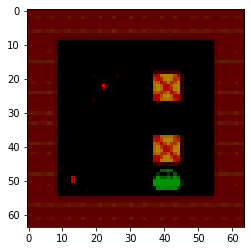

In [14]:
state_transformed = image_transformations(env.reset())
plt.imshow(state_transformed.permute(1,2,0).detach().cpu().numpy())

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
ActionLog = namedtuple('ActionLog', ['log_prob'])

In [7]:
class Net(nn.Module):
    def __init__(self, num_of_actions):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 7)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 3)
        self.pre_actions1 = nn.Linear(400, 200)
        self.pre_actions2 = nn.Linear(200, 100)
        self.actions = nn.Linear(100, num_of_actions)

    def forward(self, x):

        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = torch.flatten(x, 1) 

        actions = F.leaky_relu(self.pre_actions1(x))
        actions = F.leaky_relu(self.pre_actions2(actions))
        actions = F.leaky_relu(self.actions(actions))
        actions = F.softmax(actions, dim=1)

        return actions

    def init_weights(self):

      torch.nn.init.xavier_uniform_(self.conv1.weight)
      torch.nn.init.xavier_uniform_(self.conv2.weight)
      torch.nn.init.xavier_uniform_(self.conv3.weight)
      torch.nn.init.xavier_uniform_(self.pre_actions1.weight)
      torch.nn.init.xavier_uniform_(self.pre_actions2.weight)

      torch.nn.init.xavier_uniform_(self.actions.weight)

  

      return self

class Agent:
    def __init__(self, net):
        self.net = net 

        self.saved_actions = []
        self.rewards = []

    def run_on_state(self, state):

        state = state.to(device)
        actions_prob = self.net(state)
      
        return  actions_prob


In [8]:
GAMMA = 0.9
EPS_START = 1.0
EPS_END = 0.2
EPS_DECAY = 6000
steps_done = 0

In [9]:
def select_action(state, not_allowed_actions = None):
  
    global steps_done
    steps_done += 1

    state_tensor = image_transformations(state).unsqueeze(0)
    probs = model.run_on_state(state_tensor)
    categorical = Categorical(probs)

    action = categorical.sample()

    # while not_allowed_actions is not None and any(not_allowed_actions) and  action.item() in not_allowed_actions:
    #   action = categorical.sample()



    model.saved_actions.append(ActionLog(categorical.log_prob(action)))


    return action.item()

In [10]:
def train_on_episode():

    saved_actions = model.saved_actions
    policy_losses = [] 
    returns = []

    step_total_r = 0
    for step_immediate_rewars in reversed(model.rewards):
        step_total_r = step_immediate_rewars + GAMMA * step_total_r
        returns.insert(0, step_total_r)

    returns = torch.tensor(returns).to(device)

    returns = (returns - returns.mean()) / (returns.std() + eps)

    prev_state = None
    prev_action = None
    for (saved_action, step_total_r) in zip(saved_actions, returns):

        # policy_losses.append(-saved_action.log_prob * step_total_r)
        policy_losses.append(-saved_action.log_prob * step_total_r)


    optimizer.zero_grad()
  
    loss = torch.cat(policy_losses).sum()

    loss.backward()
    optimizer.step()
    
    model.rewards = []
    model.saved_actions = []

    return loss

In [21]:
net = Net(num_of_actions).init_weights().to(device)

model = Agent(net)

optimizer = optim.SGD(net.parameters(), lr=0.0001)

eps = np.finfo(np.float32).eps.item()

In [22]:
episodes_durations = []
steps_done = 0
net.train()


for episode_number in count(1):

  if episode_number > 5000:
    break
  if episode_number % 50 == 0:
    print('episode_number {}'.format(episode_number))

  state = env.reset()


  #not_allowed_actions = None
  for step_number in range(1, 10000):
    #prev_state = state 
    action = select_action(state)
  
    state, reward, done, _ = env.step(action)
    
    # if prev_state is not None and np.array_equal(prev_state, state):
    #   not_allowed_actions = not_allowed_actions if not_allowed_actions is not None else []

    #   not_allowed_actions.append(action)

    # else:
    #   not_allowed_actions = None
    
    #prev_state = state

    model.rewards.append(reward)

    if done:
      episodes_durations.append(step_number)
      break

  train_on_episode()



episode_number 50
episode_number 100
episode_number 150
episode_number 200
episode_number 250
episode_number 300
episode_number 350
episode_number 400
episode_number 450
episode_number 500
episode_number 550
episode_number 600
episode_number 650
episode_number 700
episode_number 750
episode_number 800
episode_number 850
episode_number 900
episode_number 950
episode_number 1000
episode_number 1050
episode_number 1100
episode_number 1150
episode_number 1200
episode_number 1250
episode_number 1300
episode_number 1350
episode_number 1400
episode_number 1450
episode_number 1500
episode_number 1550
episode_number 1600
episode_number 1650
episode_number 1700
episode_number 1750
episode_number 1800
episode_number 1850
episode_number 1900
episode_number 1950
episode_number 2000
episode_number 2050
episode_number 2100
episode_number 2150
episode_number 2200
episode_number 2250
episode_number 2300
episode_number 2350
episode_number 2400
episode_number 2450
episode_number 2500
episode_number 2550


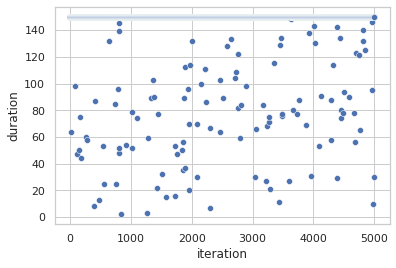

In [23]:

durations_df = pd.DataFrame([(iteration, duration) for (iteration, duration) in enumerate(episodes_durations)], columns =["iteration", "duration"])
sns.set_theme(style="whitegrid")

sns.scatterplot(data=durations_df, x="iteration", y="duration")

In [17]:
state = env.reset()

In [18]:

net.eval()
net.to(device)
state1 = image_transformations(state).unsqueeze(0).to(device)

net(state1)

tensor([[0.0731, 0.0731, 0.0731, 0.0731, 0.0826, 0.0731, 0.0817, 0.0926, 0.0732,
         0.0850, 0.0732, 0.0730, 0.0732]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

0.82254

In [137]:
saved_actions = model.saved_actions
policy_losses = [] 
returns = []

step_total_r = 0
for step_immediate_rewars in reversed(model.rewards):
  step_total_r = step_immediate_rewars + GAMMA * step_total_r
  returns.insert(0, step_total_r)

returns = torch.tensor(returns).to(device)

returns = (returns - returns.mean()) / (returns.std() + eps)

for (saved_action, step_total_r) in zip(saved_actions, returns):
  # policy_losses.append(-saved_action.log_prob * step_total_r)
  policy_losses.append(saved_action.log_prob * step_total_r)

   
optimizer.zero_grad()
  
loss = torch.cat(policy_losses).sum()

loss.backward()
optimizer.step()

model.rewards = []
model.saved_actions = []    
loss


# loss = 
# loss

tensor(2.0550, device='cuda:0', grad_fn=<SumBackward0>)

In [142]:



state1 = image_transformations(state).unsqueeze(0)
probs = model.run_on_state(state1)
probs
# categorical = Categorical(probs)

# action = categorical.sample()
# action, probs, categorical.log_prob(action)

# model.saved_actions.append(ActionLog(categorical.log_prob(action)))

tensor([[5.4675e-04, 8.2254e-01, 5.6333e-04, 5.5430e-04, 5.6239e-04, 5.4557e-04,
         5.3103e-04, 7.9609e-04, 1.3101e-01, 5.6406e-04, 5.5700e-04, 4.0683e-02,
         5.5461e-04]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [154]:
# [(a.log_prob, a.action) for a in saved_actions]